<a href="https://colab.research.google.com/github/matsunil/hdsi/blob/main/hdsi_hf_session_p2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MIT License
#
# @title Copyright (c) 2025 Mauricio Tec { display-mode: "form" }

# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.


# Welcome to the Part II of the HuggingFace session of the HDSI GenAI Workshop


<img src="https://drive.google.com/uc?export=view&id=1q4SGPmn6sWQhskt4D-1D09q_6C9FDz_L" alt="drawing" width="400"/>


# **Part II Fine-tuning LLMs**

<a target="_blank" href="https://colab.research.google.com/github/mauriciogtec/hdsi-winter-workshop/blob/main/llm-agents-part2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Expected completion time: 30 minutes.

Recommended Compute: Free T4 GPUs from Google Colab for the first part, and an A100 GPU for training


## Oct 14, 2025  <br> Mauricio Tec, Michelle Audirac



**TL;DR** Our previous tutorial gave us the tools to understand agentic LLM workflows. In this tutorial we will talk about learning. We will use fine tuning to improve the LLM for specific tasks.

🔥🔥 📚 **Let's learn how to learn** 📚🔥🔥

*Familiarity with PyTorch models is assumed.*


<br>


<img src="https://drive.google.com/uc?export=view&id=1e3nRrx9IT5BjhWFwk1VKHS-a6m0EoMhc" alt="drawing" width="450"/>


# Software Prerequisites & Setup


## Utility Function: Markdown Printing

We will define a very simple utility function to print nicely in a colab notebook environment with Markdown. This is not really needed, but it will make some output visualizations easier and nicer.


In [ ]:
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

test = "`This is code`. *This is italics*. **This is bold**."
printmd(test)

`This is code`. *This is italics*. **This is bold**.

## Install Requirements

* The main tool will be `PyTorch`, which is the most common deep learning research framework.

<img src="https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png" alt="drawing" width="300"/>


* Our second main tool, more specific to this tutorial, is the  `transformers` library, which provides access to various open-source `LLMs` as PyTorch. With transformers we have access to their internals, code, and weights.
* The `HuggingFace` tool ecosystem includes various other packages that we will need to be able to manipulate such massive models, which go beyond standard neural network training. Examples include `peft` and `accelerate`.
 <!-- For reinforcement learning and finetuning, we will use the `trl` library, which includes functionality for finetuning. -->


<img src="https://drive.google.com/uc?export=view&id=1RGuWtGHW88vk7T5JyMjnepG9YzwKJEVM" alt="drawing" width="600"/>


* 🎮 Let's play a game! While the techniques we will study apply to many environments. We will base our tutorial one nice text-based game called `TextWorld`.  

<img src="https://drive.google.com/uc?export=view&id=1fdfrUd4gxsute0b6qRdZ5d6l4y16D6UK" alt="drawing" width="600"/>


In [ ]:
%pip install -q -U \
  transformers[torch,accelerate] \
  textworld-express

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 120.5 MB/s eta 0:00:00


## 🤗 The HuggingFace Transformer Model 🤗

We will be working with the `Qwen/Qwen3-0.6B` model. Let us check access.


In [ ]:
# @title Step 0: Get the model and tokenizer
import torch
import transformers

model_id = "Qwen/Qwen3-0.6B"
device = "cuda" if torch.cuda.is_available() else "cpu" # Run GPU or CPU

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    dtype=torch.float16, # Uses less memory and is faster this way
    device_map="auto",  # Runs in GPU if you have one
)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json:   0%|          | 0.00/726 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
# @title Step 1: Apply the Prompt Template and Tokenize

# First convert to conversational form and use the chat tempalte
messages= [
    {"role": "user", "content": "What is the prime number after 121"}
]

# Tokenize
full_prompt = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=False # So we can see it in words, with tokenize in the next line
  )
inputs = tokenizer(full_prompt, return_tensors="pt").to(device)

print(f"### Full prompt\n{full_prompt}")
print(f"### Tokenized prompt\n{inputs}")

### Full prompt
<|im_start|>user
What is the prime number after 121<|im_end|>
<|im_start|>assistant

### Tokenized prompt
{'input_ids': tensor([[151644,    872,    198,   3838,    374,    279,  10250,   1372,   1283,
            220,     16,     17,     16, 151645,    198, 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}


In [ ]:
#@title Step 2: Generate text with model.generate()


# Generate
with torch.inference_mode():  # always use inference mode unless training
    gen = model.generate(**inputs, max_new_tokens=2000)[0]

# Response has the original inputs, so remove them from response
num_inputs = len(inputs["input_ids"][0])
gen = gen[num_inputs:]

# Decode to text
full_response = tokenizer.decode(gen, skip_special_tokens=False)

print(f"### Tokenized model output\n{gen}")
print(f"### Full response\n{full_response}")


### Tokenized model output
tensor([151667,    198,  32313,  ...,    532,  14085, 151645], device='cuda:0')
### Full response
<think>
Okay, so I need to find the prime number that comes right after 121. Let me think. First, I remember that a prime number is a number greater than 1 that has no divisors other than 1 and itself. So, 121 is the number we're looking at. Let me start by checking if 121 is prime.

Hmm, 121. Let me try dividing it by smaller numbers. Let's see, 121 divided by 2? No, it's not even. Divided by 3? Let me add the digits: 1 + 2 + 1 = 4, which isn't divisible by 3. Divided by 5? Ends with a 1, so no. Divided by 7? Let me do 7 times 17 is 119, which is 2 less than 121, so 121 divided by 7 is 17.2... not an integer. 7 times 17 is 119, so 121 - 119 is 2. So, not divisible by 7. 

What about 11? Let me check. 11 times 11 is 121. Oh! So, 121 is 11 squared. Therefore, it's not a prime number. Because a prime number has to have no divisors except 1 and itself. Since 11 time

In [ ]:
# @title Let's make this sequence of steps a convenient function
import re

# Utility to generate text
def call_llm(messages, model, enable_thinking=False, verbose=False, max_new_tokens=100):
    """Simple function to call the model."""
    # Get model device (GPU or CPU usually)
    device = next(model.parameters()).device
    results = {}

    # Tokenize
    full_prompt = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        enable_thinking=enable_thinking,
        tokenize=False
      )
    inputs = tokenizer(full_prompt, return_tensors="pt").to(device)
    results["full_prompt"] = full_prompt
    results["tokenized_prompt"] = inputs

    # Generate
    with torch.inference_mode():
        gen = model.generate(**inputs, max_new_tokens=max_new_tokens)[0]

    # Remove generation tokens
    num_inputs = len(inputs["input_ids"][0])
    gen = gen[num_inputs:]

    if verbose:
        print(f"== Generated tokens ==\n{gen}")

    # Decode to text
    full_response = tokenizer.decode(gen, skip_special_tokens=True)

    # Some magic to split thoughts from response
    if enable_thinking:
        # match everything in  the <think>.</think>
        thoughts = re.findall(r"<think>.*?</think>", full_response, re.DOTALL)
        if len(thoughts) > 0: # match found
            results["thoughts"] = thoughts[0]
            full_response = full_response.replace(thoughts[0], "")

    results["full_response"] = full_response

    return results

In [ ]:
call_llm(messages, model, enable_thinking=False, max_new_tokens=2000, verbose=True)

== Generated tokens ==
tensor([   785,   1372,   3070,     16,     17,     16,    334,    374,    264,
          3070,  37476,    315,    220,     16,     16,    334,     13,   8704,
           220,     16,     16,    374,    264,  10250,   1372,     11,   3070,
            16,     17,     16,    374,    264,   4727,   9334,    315,    264,
         10250,   1372,  97219,    323,   8916,   3070,     16,     17,     16,
           374,   1083,    264,  10250,   1372,    334,    382,  11209,     11,
           279,   3405,    374,  10161,    369,    279,   3070,  32338,   1372,
          1283,    220,     16,     17,     16,    334,     13,   6771,    594,
         37163,   1447,     12,    576,   1372,   3070,     16,     17,     16,
           334,    374,   3070,   1921,    264,  10250,   1372,    334,    624,
            12,    576,   1790,  10250,   1372,   1283,    220,     16,     17,
            16,    374,   3070,     16,     17,     22,    334,    382,   4416,
           279,  

{'full_prompt': '<|im_start|>user\nWhat is the prime number after 121<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n',
 'tokenized_prompt': {'input_ids': tensor([[151644,    872,    198,   3838,    374,    279,  10250,   1372,   1283,
             220,     16,     17,     16, 151645,    198, 151644,  77091,    198,
          151667,    271, 151668,    271]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')},
 'full_response': "The number **121** is a **square of 11**. Since 11 is a prime number, **121 is a perfect square of a prime number**, and therefore **121 is also a prime number**.\n\nHowever, the question is asking for the **prime number after 121**. Let's clarify:\n\n- The number **121** is **not a prime number**.\n- The next prime number after 121 is **127**.\n\nSo the answer is: **127**."}

In [ ]:
call_llm(messages, model, enable_thinking=True, max_new_tokens=2000, verbose=True)

== Generated tokens ==
tensor([151667,    198,  32313,     11,   1077,    752,   1430,    311,   7071,
           700,    279,  10250,   1372,   1283,    220,     16,     17,     16,
            13,  88190,     11,   1156,     11,    358,   1184,    311,   1779,
           421,    220,     16,     17,     16,    374,    264,  10250,   1372,
            13,  13824,     11,    220,     16,     17,     16,    374,    220,
            16,     16,  52263,     11,   1290,     30,   9211,    220,     16,
            16,   3039,    220,     16,     16,    374,    220,     16,     17,
            16,     13,   2055,    220,     16,     17,     16,    374,    537,
           264,  10250,   1372,     13,    576,   3405,    374,  10161,    369,
           279,  10250,   1372,    429,   4041,   1290,   1283,    220,     16,
            17,     16,     13,   4710,   3983,   3783,     11,    220,     16,
            17,     16,    374,    220,     16,     16,  29456,     11,    773,
           279,  

{'full_prompt': '<|im_start|>user\nWhat is the prime number after 121<|im_end|>\n<|im_start|>assistant\n',
 'tokenized_prompt': {'input_ids': tensor([[151644,    872,    198,   3838,    374,    279,  10250,   1372,   1283,
             220,     16,     17,     16, 151645,    198, 151644,  77091,    198]],
        device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
        device='cuda:0')},
 'thoughts': "<think>\nOkay, let me try to figure out the prime number after 121. Hmm, first, I need to check if 121 is a prime number. Wait, 121 is 11 squared, right? Because 11 times 11 is 121. So 121 is not a prime number. The question is asking for the prime number that comes right after 121. \n\nBut wait, 121 is 11², so the numbers after that would be 122, 123, 124, etc. But none of those numbers are prime except maybe 122? Wait, 122 is 2 times 61, so it's not prime. 123 is 3 times 41, so not prime. 124 is 4 times 31. 125 is 5 times 25. 126 is 6 

⚠️ As you can see from the line above. Thinking mode is extremely verbose. We will use our own custom version more compact.

## 🎮 The TextWorld Interactive Environment 🎮

Let's start the fun 🤩. We will play the`twc` (TextWorld common sense) games. There is the documentation's description of the game:

> `TextWorld Common Sense (twc)`

> Text game agents frequently learn the dynamics of environment --
such as the need to open a door before one can move through it --
from interacting with the environment itself, rather than using a pre-existing
knowledge base of common sense facts or object affordances that would speed
task learning. TextWorld Commonsense [Murugesan etal., 2021](https://arxiv.org/abs/2010.03790)
aims to evaluate agents on common sense knowledge that can not be directly learned from the
environment by providing agents a clean-up task where the agent must place
common household objects (e.g., a dirty dish) in their canonical locations
(e.g., the dishwasher) that can be found in knowledge bases such as ConceptNet.
Separate lists of objects are used in the training, development, and test sets,
meaning the agent can not learn object locations from the training set alone,
and must rely on an external common sense knowledge base to perform well on the
development and test sets. TextWorld Commonsense benchmark has three task
difficulty levels, with the easiest including a single location and object to
put away, while the hard setting includes up to p to 11 locations and any number
of task-relevant and distractor objects.

In [ ]:
import random
from textworld_express import TextWorldExpressEnv


#  Textworld game Engine Creator
def env_factory(
    gameName: str = "twc",
    gameParams: str = "numLocations=3,includeDoors=1,numItemsToPutAway=4",
    time_limit: int = 12,
    gold_path: bool = False,
):
    env = TextWorldExpressEnv(envStepLimit=time_limit)
    env.load(gameName=gameName, gameParams=gameParams)
    return env

# Create new game instance
env = env_factory()
obs, infos = env.reset(seed=1234, gameFold="train")


# Take some random steps and collect experience in history
history = []
history.append("## Welcome to TextWorld")
history.append(f"`<Task>`: {env.getTaskDescription()}")
history.append(f"`<Starting Obs>`: {obs}")

for step_id in range(10):
    history.append(f"**Step {step_id + 1}**")

    # Select a random valid action
    randomAction = random.choice(infos['validActions'])

    # Take that action
    obs, reward, done, infos = env.step(randomAction)

    # Display action and the game's feedback.
    history.append(f"`<Valid Actions>` {infos['validActions']}")
    history.append(f"`<Action>` {randomAction}")
    history.append(f"`<Obs>` {obs}")
    history.append(f"`<Reward>` {reward:0.2f}")

history = "\n\n".join(history)
printmd(history)

## Welcome to TextWorld

`<Task>`: Your task is to pick up objects, then place them in their usual locations in the environment.

`<Starting Obs>`: You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

**Step 1**

`<Valid Actions>` ['move east', 'close door to east', 'open door to east', 'look around', 'inventory', 'take clean plate']

`<Action>` close door to east

`<Obs>` That is already closed. 

`<Reward>` 0.00

**Step 2**

`<Valid Actions>` ['look around', 'close door to east', 'open door to east', 'inventory', 'move east', 'take clean plate']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 3**

`<Valid Actions>` ['inventory', 'open door to east', 'take clean plate', 'look around', 'close door to east', 'move east']

`<Action>` move east

`<Obs>` You can't move there, the door is closed. 

`<Reward>` 0.00

**Step 4**

`<Valid Actions>` ['take clean plate', 'close door to east', 'move east', 'look around', 'open door to east', 'inventory']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
To the East you see a closed plain door. 

`<Reward>` 0.00

**Step 5**

`<Valid Actions>` ['inventory', 'move east', 'take clean plate', 'look around', 'open door to east', 'close door to east']

`<Action>` close door to east

`<Obs>` That is already closed. 

`<Reward>` 0.00

**Step 6**

`<Valid Actions>` ['open door to east', 'inventory', 'move east', 'close door to east', 'look around', 'take clean plate']

`<Action>` inventory

`<Obs>` Inventory: 
  Your inventory is currently empty.


`<Reward>` 0.00

**Step 7**

`<Valid Actions>` ['open door to east', 'take clean plate', 'inventory', 'close door to east', 'look around', 'move east']

`<Action>` close door to east

`<Obs>` That is already closed. 

`<Reward>` 0.00

**Step 8**

`<Valid Actions>` ['close door to east', 'open door to east', 'take clean plate', 'inventory', 'look around', 'move east']

`<Action>` open door to east

`<Obs>` You open the plain door, revealing the kitchen. 

`<Reward>` 0.00

**Step 9**

`<Valid Actions>` ['take clean plate', 'look around', 'inventory', 'move east', 'close door to east', 'open door to east']

`<Action>` look around

`<Obs>` You are in the pantry. In one part of the room you see a folding chair, that has nothing on it. There is also a shelf, that has nothing on it. You also see a clean plate. 
Through an open plain door, to the East you see the kitchen. 

`<Reward>` 0.00

**Step 10**

`<Valid Actions>` ['open door to east', 'take clean plate', 'look around', 'close door to east', 'move east', 'inventory']

`<Action>` open door to east

`<Obs>` That is already open. 

`<Reward>` 0.00

# I. Benchmarking the Baseline Agents

Using what we learned in the previous part, let's evaluate how well the basic and chain of thought agents perform in TextWorld.


### Building Functionality: Creating the Planning and Action Steps

We will now implement some utility functions that will allow the agent to play the game.

#### *Coding Plan*

* 📜 **Build the task prompt** – Use `build_task_prompt(history, valid_actions)` to construct the task prompt, incorporating history and valid actions.
* 📝 **Generate a plan** – Use `planning_step(task_prompt, previous_plan=None)` to create an initial plan and revise it as new observations are made.
* 🤖 **Select the next action** – Use `action_step(task_prompt, valid_actions, example_thoughts=None)` to determine the next valid action, optionally incorporating a thought process.
* 🎯 **Ensure valid actions** – Use `extract_valid_action(response, valid_actions)` to validate and correct actions based on the valid action list.

In [ ]:
def build_task_prompt(memory):
    """Builds the task prompt from memory, including examples."""
    return "\n\n".join(memory) + "Answer the questions below. Give all answers using plain text or bullet points. Don't use hastags `#`. Prefer short answers."


def planning_step(model, task_prompt, previous_plan=None):
    """Generates a plan."""
    plan_prompt = task_prompt + "### Question\nOutline a plan to solve the task.\n"
    messages = [{"role": "user", "content": plan_prompt}]
    return call_llm(messages, model)['full_response']


def action_step(model, task_prompt, valid_actions, thinking=False):
    """Generates an action. If example thoughts are provided, it first generates thoughts before selecting an action."""

    # Use chain of thought if needed
    if thinking:
        thought_prompt = task_prompt + (
            "\n\n###Question\nLet's think step by step before deciding the best next action.\n"
            f"The valid actions are: {','.join(valid_actions)}\n"
            "\n\n###Example:\nMy task is to relocate misplaced objects. I just arrived to the kitchen. My inventory has a kitchen knife. Then, I must drop the kitcken knife here.\n"
        )
        messages = [{"role": "user", "content": thought_prompt}]
        thoughts = call_llm(messages, model)['full_response']
        task_prompt += f"\n\n[Thoughts] {thoughts}"
    else:
        thoughts = ""

    # Obtain action, ensuring validity
    task_prompt += (
        "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
         f"Your answer should be one and only of the following valid actions: {','.join(valid_actions)}\n"
         f"Example answer: {random.choice(valid_actions)}"
    )
    messages = [{"role": "user", "content": task_prompt}]
    response = call_llm(messages, model)['full_response'].strip()
    for chars in ["[", "]", "`", '"', "'", "\n", ":"]:
        response = response.replace(chars, "")
    action = extract_valid_action(model, response, valid_actions)

    return action, thoughts


def extract_valid_action(model, response, valid_actions):
    """Ensures the extracted action is valid, querying the LLM if needed."""
    action = response.strip("[]`:").strip()
    if action in valid_actions:
        return action

    correction_prompt = (
        f"The agent responded: '{response}'. However, this is not a valid action.\n"
        f"The valid action list is {valid_actions}, extract the closest correct action.\n"
        "If the response contains unnecessary words like 'You move north to take the ball.', extract only 'move north'.\n"
        "If multiple optimal actions where suggested, choose the first valid action.\n"
        "Example corrections:\n"
        "- You open the cabinet.' → open shoe cabinet\n"
        "- 'Check my bag.' → inventory\n"
        "- Move in the east direction to take pick up shows and go west.' → move east\n"
        "- move south move north → move south\n"
        "- move north, pick up shoes → move north\n"
        "- pick up shoes, move north → pick up shoes\n"
        "Return only the corrected action from the valid action list without extra words.\n"
        "For instance, in the last example, your answer should simply be: pick up shoes"
    )
    messages = [{"role": "user", "content": correction_prompt}]
    corrected_action = call_llm(messages, model)['full_response'].strip()
    return corrected_action

Let's now test these function in a single decision step.

In [ ]:
# Initialize environment
env = env_factory()
obs, infos = env.reset(gameFold="train")

# Initialize memory
valid_actions = infos['validActions']
memory = [
    "## Welcome to TextWorld",
    f"`[Task]`: {env.getTaskDescription()}",
    f"`[Starting Obs]`: {obs}",
    f"`[Valid Actions]`: {valid_actions}",
]

# Initialize prompt
task_prompt = build_task_prompt(memory)

# # Start decision making
# plan = planning_step(model, task_prompt)
# memory.append(f"`[Initial Plan]` {plan}")

action, thoughts = action_step(model, task_prompt, valid_actions, thinking=True)

obs, reward, done, infos = env.step(action)

memory.append(f"`[Thoughts]` {thoughts}")
memory.append(f"`[Action]` {action}")
memory.append(f"`[Obs]` {obs}")
memory.append(f"`[Reward]` {reward:0.2f}")

printmd("\n\n".join(memory))

## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the corridor. In one part of the room you see a key holder, that has nothing on it. There is also a shoe cabinet that is closed. You also see a umbrella stand, that has nothing on it. In another part of the room you see a hat rack, that has nothing on it. In one part of the room you see a coat hanger, that has nothing on it. 
To the South you see the kitchen. 

`[Valid Actions]`: ['open shoe cabinet', 'look around', 'inventory', 'move south']

`[Thoughts]` - look around  
- inventory  
- move south

`[Action]` inventory

`[Obs]` Inventory: 
  Your inventory is currently empty.


`[Reward]` 0.00

### Playing a Full Episode

Let's put together our functions we created above into a "rollout" loop to play a full episode.

*Coding Plan*

* 👾 The game engine must be initiated
* 📖 We ask the agent for an initial plan, and revise it so often.
* 📈 We need to keep adding observations and actions to the memory
* 💸 We need to track the total reward of the agent
* 📀 At each step, we ask the agent for the action to take using the functions we just created in the previous step.


In [ ]:
from datetime import datetime # to include time in loop
from typing import Literal  # hint valid arguments to a function
from tqdm.auto import tqdm  # progress bar


def episode_rollout(
    model: transformers.PreTrainedModel,
    gameFold: str = Literal["train", "valditation", "test"],
    thinking: bool = False,
    planning: bool = False,
    planning_interval: int = 3,
    env_factory_options: dict = {},
    seed: int = None
):
    # Set model in eval mode, no dropout, etc..)
    model.eval()

    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, seed=seed)

    # Initialize Memory
    memory = []
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")


    # Make task prompt
    task_prompt = build_task_prompt(memory)

    # Make initial plan
    if planning:
        plan = planning_step(model, task_prompt)
        memory.append(f"`[Initial Plan]`: {plan}")

    # Start loop
    done = False
    total_reward = 0.0
    pbar = tqdm(desc="Episode Progress") # progress bar
    collected_data = []  # useful for training later

    step = 0
    while not done:
        step += 1

        # Update task prompt
        memory.append(f"###  `Action step {step}`")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Get new action from LLM
        # Update task prompt before action
        action, thoughts = action_step(
            model,
            task_prompt,
            infos['validActions'],
            thinking,
        )

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        if thinking:
            memory.append(f"`[Thoughts]`:\n\n{thoughts}")
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        if planning and step % planning_interval == 0:
            plan = planning_step(model, task_prompt, plan)
            memory.append(f"`[Updated Plan]`: {plan}")

        # Append experience to data
        collected_data.append((task_prompt, thoughts, action, obs, reward))

        total_reward += reward
        pbar.update(1)

    return memory, collected_data, total_reward


memory, _, _ = episode_rollout(
    model, gameFold="test", thinking=True, env_factory_options=dict(time_limit=5),
)

printmd('\n\n'.join(memory))

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. 

###  `Action step 1`

`[Time]` 16:58:47

`[Valid Actions]`: ['open wastepaper basket', 'look around', 'inventory', 'move east']

`[Thoughts]`:

- Look around  
- Inventory  
- Move east

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. 

###  `Action step 2`

`[Time]` 16:58:47

`[Valid Actions]`: ['inventory', 'look around', 'open wastepaper basket', 'move east']

`[Thoughts]`:

- Look around  
- Inventory

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 3`

`[Time]` 16:58:48

`[Valid Actions]`: ['open wastepaper basket', 'inventory', 'look around', 'move east']

`[Thoughts]`:

- Look around  
- Inventory

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. 

###  `Action step 4`

`[Time]` 16:58:48

`[Valid Actions]`: ['inventory', 'look around', 'move east', 'open wastepaper basket']

`[Thoughts]`:

- Look around  
- Inventory

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


###  `Action step 5`

`[Time]` 16:58:48

`[Valid Actions]`: ['look around', 'move east', 'open wastepaper basket', 'inventory']

`[Thoughts]`:

- Look around  
- Inventory

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. 

###  `Action step 6`

`[Time]` 16:58:49

`[Valid Actions]`: ['move east', 'look around', 'inventory', 'open wastepaper basket']

`[Thoughts]`:

- Look around  
- Inventory

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  Your inventory is currently empty.


### Benchmark over several episodes

Now the moment of truth 😱. Let's run several episodes and collect the experience.
For the interest of time. We will pre-save these results and load them.
But feel free to re-run.

In [ ]:
import json
import requests

# Uncomment to rerun everything
baseline_episodes = {"vanilla": [], "thinking": []}

num_episodes_per_agent = 30

# for agent, results in baseline_episodes.items():
#     printmd(f"### Agent {agent}")
#     thinking = (agent == "thinking")

#     for ep in range(num_episodes_per_agent):
#         printmd(f"#### Episode {ep}")
#         memory, data, total_reward = episode_rollout(model, gameFold="test", thinking=thinking)
#         results.append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

# # Save results
# with open(f"./episodes_baseline_agents.json", "w") as f:
#     json.dump(baseline_episodes, f)

The following can be used to load pre-saved runs
url = "https://raw.githubusercontent.com/mauriciogtec/huggingface_workshop/refs/heads/main/episodes_baseline_agents.json"
response = requests.get(url)
baseline_episodes = json.loads(response.text)

# ## Comment following lines if re-running data collection
# baseline_episodes = json.load(open(f"./episodes_baseline_agents.json", "r"))

SyntaxError: invalid syntax (ipython-input-1906688042.py, line 22)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in eps])
    for a, eps in baseline_episodes.items()
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Two Agents")
plt.show()

# II. Supervised Fine-tuning (SFT) with Low-rank Adaptation (LORA)

In many problems, it is possible to collect demonstration data and learned an optimal strategy with supervision. For example, this could mean a human playing the game. In our case, text world comes with an engine to generate "gold paths" which help solve the task.

**Learning Plan**

* 📚 We will setup the LLM for efficient training using parameter efficient fine-tuning with LORA [(Hu et al., 2021)](https://arxiv.org/abs/2106.09685).
* 🥇 We will use the gold path engine to create a demonstration dataset
* 🏋️‍♀️ We will use the demonstration dataset for SFT
* 📈 We will evaluate the improved LLM

### 2.1 A primer on SFT and LORA

🕸️ LLMs are just neural networks. In particular, LLMs use the `transformer` architecture introduced in the paper *Attention Is All You Need*  [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). There is a good reason why this paper has over 100k citations ❗️


<figure>
<img src="https://drive.google.com/uc?export=view&id=1isVB0kvxCiE4Mz6eWaDaUu1QDI5BvZNC" alt="drawing" width="600"/>
<figcaption>
<b>Fig.</b> Schemetic representation of the Transformer Architecture and next-token prediction task.<br><em>Original image and blogpost</em>: <a href='https://medium.com/@akash.kesrwani99/understanding-next-token-prediction-concept-to-code-1st-part-7054dabda347'>Understanding Next Token Prediction: Concept To Code: 1st part!</a>
</figcaption>
</figure>


* 🔧 **Fine-tuning** 🔧
  * Fine tuning means updating the weights (parameters) of the neural network using a smaller dataset (aka downstream task).
  * In the context of LLM agents, we may also call this step *grounding* to the task.
  * Finetuning is typically done for far fewer optimization steps than the original training, and usually with smaller learning rates.
  * Finetuning is almost always better than training a model from scratch on the new ata.

* 🎻 **Classic approach** 🎻
  * *Last-layer tuning*: Retraining only the last layer of neural network.
  * *Full finetuning*: Update all weights of the network.
In regular neural network, it is common to update *all* the weights of neural network during finetuning.

#### 🦜 **LORA** 🦜
  * LORA takes the best of both finetuning regimes. Few parameters to train, but performs much better than last-layer tuning because it improves the entire neural network.
  * LORA or its many variations have become the standard to finetune LLMs [(Mao et al., 2024)](https://arxiv.org/abs/2407.11046)
  * The main idea is train an *low-rank adapter* as follows, which, for every parameter of the neural network, adds a new weight with fewer free parameters using the magic of low-rank matrix product factorization. The idea is illustrated below.
* 😱 **Worry not!** 😱
  * LORA is easily used without understanding its detailed inner workings.


<figure>
<img src="https://drive.google.com/uc?export=view&id=1HHeFZPdrVQWvA1EbWTHtyAuw_YNJjc-B" alt="drawing" width="800"/>
<figcaption>
<b>Fig.</b> Illustration of LORA.<br><em>Original image</em>: <a href='https://huggingface.co/docs/peft/main/en/developer_guides/lora'>HuggingFace PEFT docs</a>
</figcaption>
</figure>

#### 🏋🏽‍♂️ SFT is still next-token prediction** 🏋🏽‍♂️


In LLMs, the next-token prediction is trained using the **Cross-entropy Loss**, which measures how well the model's predicted probability distribution aligns with the true next token. SFT still uses this loss.

$$
\mathcal{L} = - \frac{1}{N} \sum_{i=1}^{N} \log \hat{P}_{\theta}(x_i | x_{<i})
$$

where:
- $N$ is the number of tokens in the sequence,
- $\hat{P}_{\theta}(x_i | x_{<i})$ represents the **predicted probability** of the correct token $x_i$ given the previous tokens,
- $x_{<i}$ represents the **context** (all previous tokens up to position $i$).

Since modern LLMs output **logits** (unnormalized scores for each token in the vocabulary), the probability $\hat{P}_{\theta}(x_i | x_{<i})$ is obtained by applying a **softmax**:

$$
\hat{P}_{\theta}(x_i | x_{<i}) = \frac{\exp(\text{logit}_{i, x_i})}{\sum_{j=1}^{V} \exp(\text{logit}_{i, j})}
$$

where:
- $\text{logit}_{i, x_i}$ is the model's predicted score for the correct next token $x_i$ at position $i$,
- $V$ is the vocabulary size,
- The denominator sums over all token scores to normalize them.


🐍 Cross-entropy in Pytorch 🐍

The cross-entropy is computed using `torch.nn.functional.cross_entropy`, which **directly takes raw logits** (not softmaxed) and target indices:

```python
# Example logits from a model (batch_size=1, seq_len=5, vocab_size=10)
logits = torch.tensor([
    [  # Sequence of 5 tokens (seq_len=5), each with vocab_size=10 logits
        [2.0, 1.0, 0.1, 3.2, 0.5, 2.3, 1.1, 0.2, 0.4, 1.7],  # Token 1
        [1.1, 2.5, 0.3, 2.8, 1.6, 1.7, 0.5, 0.7, 0.9, 1.3],  # Token 2
        [0.9, 1.4, 3.1, 1.5, 1.3, 0.8, 2.1, 1.9, 2.4, 0.7],  # Token 3
        [2.2, 0.5, 1.7, 1.8, 0.3, 2.6, 1.2, 1.5, 1.9, 0.6],  # Token 4
        [1.7, 2.2, 1.0, 1.4, 2.3, 0.9, 1.5, 1.6, 2.1, 1.8]   # Token 5
    ]
])  # Shape: (batch_size=1, seq_len=5, vocab_size=10)

# Target tokens (ground truth indices), same shape as seq_len
targets = torch.tensor([[3, 1, 2, 5, 4]])  # Shape: (batch_size=1, seq_len)

# Compute cross-entropy loss directly
loss = torch.nn.functional.cross_entropy(logits, targets)
```

### 2.2 Gather the Demonstration dataset

The strategy will be to mimic our previous episode_rollout busing the `env.getGoldActionSequence()` feature and execute that path.

In [ ]:
def expert_episode_rollout(
    gameFold: str = Literal["train", "valditation", "test"],
    env_factory_options: dict = {},
):
    # Initialize env
    env = env_factory(**env_factory_options)
    obs, infos = env.reset(gameFold=gameFold, generateGoldPath=True)
    gold_actions = env.getGoldActionSequence()

    # Initialize Memory
    memory = []
    memory.append("## Welcome to TextWorld")
    memory.append(f"`[Task]`: {env.getTaskDescription()}")
    memory.append(f"`[Starting Obs]`: {obs}")

    # Make initial plan
    # Print progress
    pbar = tqdm(desc="Episode Progress")

    # Collected prompt/action/reward triples for training
    collected_data = []

    # Start loop
    done = False
    total_reward = 0.0

    step = 0
    while not done:
        # Update task prompt
        memory.append(f"***`Action step {step}`**")
        memory.append(f"`[Time]` {datetime.now().strftime('%H:%M:%S')}")
        memory.append(f"`[Valid Actions]`: {infos['validActions']}")
        task_prompt = build_task_prompt(memory)

        # Execute gold path action
        action = gold_actions[step]

        # Advance the Environment
        obs, reward, done, infos = env.step(action)

        # Update memory
        memory.append(f"`[Action]`: {action}")
        memory.append(f"`[Reward]`: {reward:0.2f}")
        memory.append(f"`[Obs]`: {obs}")

        collected_data.append((task_prompt, "", action, reward))  # empty for the thoughts

        total_reward += reward
        step += 1
        pbar.update(1)

    return memory, collected_data, total_reward

In [ ]:
expert_episodes = {'expert': []}

num_episodes_per_agent = 20

for ep in range(num_episodes_per_agent):
    memory, data, total_reward = expert_episode_rollout(gameFold="train")
    expert_episodes['expert'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

mean_reward_expert = np.mean([ep["total_reward"] for ep in expert_episodes["expert"]])
print(f"Mean reward for expert: {mean_reward_expert}")

# Visualize expert episode
printmd('\n\n'.join(expert_episodes['expert'][0]['memory']))

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Episode Progress: 0it [00:00, ?it/s]

Mean reward for expert: 0.74375


## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a black duvet. There is also a clean blue blazer. 
To the West you see a closed wood door. 

***`Action step 0`**

`[Time]` 16:50:11

`[Valid Actions]`: ['look around', 'take clean blue blazer', 'open door to west', 'close door to west', 'take black duvet', 'inventory', 'move west', 'open wastepaper basket']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a black duvet. There is also a clean blue blazer. 
To the West you see a closed wood door. 

***`Action step 1`**

`[Time]` 16:50:11

`[Valid Actions]`: ['take clean blue blazer', 'open door to west', 'close door to west', 'inventory', 'open wastepaper basket', 'move west', 'take black duvet', 'look around']

`[Action]`: take black duvet

`[Reward]`: 0.12

`[Obs]`: You take the black duvet.

***`Action step 2`**

`[Time]` 16:50:11

`[Valid Actions]`: ['put black duvet in sofa', 'take clean blue blazer', 'put black duvet in arm chair', 'put black duvet in end table', 'put black duvet in side table', 'put black duvet in book case', 'open door to west', 'put black duvet in TV stand', 'move west', 'inventory', 'open wastepaper basket', 'close door to west', 'look around', 'put black duvet in coffee table']

`[Action]`: take clean blue blazer

`[Reward]`: 0.12

`[Obs]`: You take the clean blue blazer.

***`Action step 3`**

`[Time]` 16:50:11

`[Valid Actions]`: ['put black duvet in arm chair', 'put black duvet in end table', 'open wastepaper basket', 'put clean blue blazer in arm chair', 'put black duvet in book case', 'inventory', 'look around', 'put clean blue blazer in book case', 'put black duvet in sofa', 'open door to west', 'close door to west', 'put clean blue blazer in TV stand', 'put clean blue blazer in side table', 'put black duvet in TV stand', 'put clean blue blazer in end table', 'put black duvet in side table', 'put black duvet in coffee table', 'put clean blue blazer in coffee table', 'put clean blue blazer in sofa', 'move west']

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bedroom. 

***`Action step 4`**

`[Time]` 16:50:11

`[Valid Actions]`: ['close door to west', 'inventory', 'put black duvet in TV stand', 'put clean blue blazer in arm chair', 'put clean blue blazer in coffee table', 'open wastepaper basket', 'put clean blue blazer in end table', 'look around', 'put black duvet in side table', 'put black duvet in arm chair', 'put black duvet in end table', 'put clean blue blazer in sofa', 'open door to west', 'put clean blue blazer in side table', 'put black duvet in sofa', 'put clean blue blazer in book case', 'put black duvet in book case', 'put black duvet in coffee table', 'move west', 'put clean blue blazer in TV stand']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
To the South you see a closed wood door. Through an open wood door, to the East you see the living room. 

***`Action step 5`**

`[Time]` 16:50:11

`[Valid Actions]`: ['move east', 'put clean blue blazer in desk chair', 'open door to east', 'put black duvet in bed', 'move south', 'close door to east', 'open wardrobe', 'put black duvet in desk', 'put black duvet in dressing table', 'put black duvet in night stand', 'close door to south', 'put black duvet in desk chair', 'put clean blue blazer in dressing table', 'look around', 'put clean blue blazer in bed', 'open door to south', 'put clean blue blazer in night stand', 'open chest of drawers', 'inventory', 'put clean blue blazer in desk']

`[Action]`: open chest of drawers

`[Reward]`: 0.00

`[Obs]`: You open the chest of drawers. It's empty inside.

***`Action step 6`**

`[Time]` 16:50:11

`[Valid Actions]`: ['open door to south', 'inventory', 'put clean blue blazer in bed', 'put black duvet in desk chair', 'put clean blue blazer in night stand', 'put black duvet in bed', 'move south', 'put black duvet in desk', 'put clean blue blazer in desk chair', 'put black duvet in night stand', 'close door to east', 'close chest of drawers', 'close door to south', 'open door to east', 'put black duvet in dressing table', 'put clean blue blazer in dressing table', 'put black duvet in chest of drawers', 'move east', 'look around', 'open wardrobe', 'put clean blue blazer in desk', 'put clean blue blazer in chest of drawers']

`[Action]`: put black duvet in chest of drawers

`[Reward]`: 0.12

`[Obs]`: You put the black duvet in the chest of drawers.

***`Action step 7`**

`[Time]` 16:50:11

`[Valid Actions]`: ['open door to east', 'open door to south', 'move east', 'close door to south', 'inventory', 'put clean blue blazer in night stand', 'put clean blue blazer in desk', 'take black duvet', 'put clean blue blazer in dressing table', 'close chest of drawers', 'close door to east', 'open wardrobe', 'put clean blue blazer in chest of drawers', 'move south', 'put clean blue blazer in bed', 'look around', 'put clean blue blazer in desk chair']

`[Action]`: open wardrobe

`[Reward]`: 0.00

`[Obs]`: You open the wardrobe. It's empty inside.

***`Action step 8`**

`[Time]` 16:50:11

`[Valid Actions]`: ['close door to east', 'open door to south', 'move east', 'close wardrobe', 'put clean blue blazer in wardrobe', 'open door to east', 'close door to south', 'put clean blue blazer in desk', 'take black duvet', 'look around', 'put clean blue blazer in desk chair', 'put clean blue blazer in bed', 'put clean blue blazer in night stand', 'close chest of drawers', 'inventory', 'put clean blue blazer in chest of drawers', 'put clean blue blazer in dressing table', 'move south']

`[Action]`: put clean blue blazer in wardrobe

`[Reward]`: 0.12

`[Obs]`: You put the clean blue blazer in the wardrobe.

***`Action step 9`**

`[Time]` 16:50:11

`[Valid Actions]`: ['close door to south', 'open door to south', 'close chest of drawers', 'open door to east', 'move east', 'inventory', 'take black duvet', 'look around', 'take clean blue blazer', 'close door to east', 'move south', 'close wardrobe']

`[Action]`: open door to south

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the corridor. 

***`Action step 10`**

`[Time]` 16:50:11

`[Valid Actions]`: ['open door to south', 'open door to east', 'take black duvet', 'close door to east', 'inventory', 'close wardrobe', 'take clean blue blazer', 'move south', 'close chest of drawers', 'move east', 'look around', 'close door to south']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
Through an open wood door, to the West you see the bedroom. 

***`Action step 11`**

`[Time]` 16:50:11

`[Valid Actions]`: ['inventory', 'close door to west', 'move west', 'open door to west', 'look around', 'open wastepaper basket']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see An open chest of drawers, that contains a black duvet. In one part of the room you see An open wardrobe, that contains a clean blue blazer. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
Through an open wood door, to the South you see the corridor. Through an open wood door, to the East you see the living room. 

***`Action step 12`**

`[Time]` 16:50:11

`[Valid Actions]`: ['take black duvet', 'close door to east', 'close wardrobe', 'close chest of drawers', 'move east', 'open door to south', 'move south', 'open door to east', 'close door to south', 'look around', 'inventory', 'take clean blue blazer']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
Through an open wood door, to the West you see the bedroom. 

With this explanation in mind, let us start with collecting the expert data into a more usable format.

In [ ]:
# 1. Combine all the data
data_list = []
for ep in expert_episodes["expert"]:
    for prompt, _, action, _ in ep["data"]:
        data_list.append({"prompt": prompt, "action": action})
data_list[0]

{'prompt': "## Welcome to TextWorld\n\n`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.\n\n`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a black duvet. There is also a clean blue blazer. \nTo the West you see a closed wood door. \n\n***`Action step 0`**\n\n`[Time]` 16:50:11\n\n`[Valid Actions]`: ['look around', 'take clean blue blazer', 'open door to west', 'close door to west', 'take black duvet', 'inventory', 'move west', 'o

### 2.3 Training / Fine-tuning


We now use the `peft` library to setup LORA. Incredibly, only 0.03% of the weights will need to be updated.

In [ ]:
import peft
from peft import LoraConfig, TaskType

# LORA config
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=4,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none"
)

# Wrap the original model. The wrapped model has fewer trainable paramters
model_lora = peft.get_peft_model(model, peft_config)
model_lora.print_trainable_parameters()

display(model_lora)

trainable params: 573,440 || all params: 596,623,360 || trainable%: 0.0961


/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen3ForCausalLM(
      (model): Qwen3Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-27): 28 x Qwen3DecoderLayer(
            (self_attn): Qwen3Attention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_fea

Next, let's break down an example of how we compute the loss with one of the entries of our collected data.

ℹ️ Pay attention to the tokenizations scheme. It's easy to miss! We need to make sure the prompt is transformed to the chat template used by the LLM ℹ️

In [ ]:
prompt, action = data_list[0]["prompt"], data_list[0]["action"]

# we need to obtain the full prompt first
action_prompt = prompt + (
    "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
      f"The valid actions are: {','.join(valid_actions)}\n"
)
messages = {"role": "user", "content": action_prompt}
full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!!
tokenized_prompt = tokenizer(full_prompt, return_tensors="pt").input_ids.to("cuda")[0]
tokenized_action = tokenizer(action_with_eot, return_tensors="pt").input_ids.to("cuda")[0]

print(f"> Prompt: {full_prompt}\n")
print(f"> Tokenized Prompt: {tokenized_prompt}\n")
print(f"> Action: {action_with_eot}\n")
print(f"> Tokenized Action: {tokenized_action}\n")

# concatenate prompt/action that will be the input to the language model for next
# token prediction. We don't need to include the last token of the action, since
# it is only used as a label for the next token prediction later.
device = "cuda" if torch.cuda.is_available() else "cpu"
input_ids = torch.cat([tokenized_prompt, tokenized_action[:-1]]).to(device)

# eval LLM - we need the extra dimension since the model expects a batch
# this is achieved by unsqueeze(0)
outputs = model_lora(input_ids.unsqueeze(0))
print(f"> Model outputs: {outputs}")

# Now we will compute the next token prediction loss, but only on the last tokens
# for the action.
# The loss is the cross entropy with the logits and the true next tokens (i.e., the action tokens)
num_action_tokens = len(tokenized_action)
next_token_logits = outputs.logits[0, -num_action_tokens:]
loss = torch.nn.functional.cross_entropy(next_token_logits, tokenized_action)
print(f"> Cross entropy loss Loss: {loss:.2f}")

# clean up
del outputs, loss, next_token_logits
torch.cuda.empty_cache()

> Prompt: <|im_start|>user
## Welcome to TextWorld

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a black duvet. There is also a clean blue blazer. 
To the West you see a closed wood door. 

***`Action step 0`**

`[Time]` 16:50:11

`[Valid Actions]`: ['look around', 'take clean blue blazer', 'open door to west', 'close door to west', 'take black duvet', 'inventory', 'move west'


🏋️‍♀️ **We are ready to train**🏋️‍♀️ All that is left is to compute the loss and call the optimizer ineach step.

𝝯 **Gradient accumulation** 𝝯 We did not implement batches, which is typically used to improve training. But we can use a very simple trick called gradient accumulation. This trick is handy particularly with larger models when batched training does not fit in memory.


In [ ]:
import accelerate
import peft


def train(model, tokenizer, data_list, epochs=20):
    """
    Train function that ensures memory is freed after training.

    Args:
        model (torch.nn.Module): The model to be trained.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for processing text inputs.
        data_list (list): The dataset containing prompts and actions.
        epochs (int, optional): Number of epochs. Defaults to 20.
    """
    # Set model in train mode (e.g., dropout on)
    model.train()

    # standard choice of optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-5,
        betas=(0.9, 0.95),
        eps=1e-8,
        weight_decay=0.01,
    )

    # accelerator for the gradient accumulation and device management
    accelerator = accelerate.Accelerator(gradient_accumulation_steps=4)
    model, optimizer = accelerator.prepare(model, optimizer)
    device = accelerator.device

    all_losses = []

    # training loop
    for epoch in range(epochs):
        epoch_losses = []

        # random order of data
        indices = np.random.permutation(len(data_list))

        for i in tqdm(range(len(data_list))):
            data = data_list[indices[i]]
            action = data["action"]
            task_prompt = data["prompt"]

            # Make full prompt
            action_prompt = task_prompt + (
                "\n\nNow, choose exactly one valid action from the list and no additional information.\n"
                f"The valid actions are: {','.join(valid_actions)}\n"
            )
            messages = {"role": "user", "content": action_prompt}
            full_prompt = tokenizer.apply_chat_template([messages], tokenize=False, add_generation_prompt=True)

            # Tokenize inputs and move to device
            prompt_tokens = tokenizer(full_prompt, return_tensors="pt").input_ids.to(device)[0]
            action_with_eot = action + "<|eot_id|><|start_header_id|>assistant<|end_header_id|>" # !!!! Easy to miss
            action_tokens = tokenizer(action_with_eot, return_tensors="pt").input_ids.to(device)[0]
            input_ids = torch.cat([prompt_tokens, action_tokens[:-1]])

            # Compute loss with gradient accumulation
            with accelerator.accumulate(model):
                outputs = model(input_ids.unsqueeze(0))
                num_action_tokens = len(action_tokens)
                next_token_logits = outputs.logits[0, -num_action_tokens:]
                loss = torch.nn.functional.cross_entropy(next_token_logits, action_tokens)

            optimizer.zero_grad()
            accelerator.backward(loss)
            optimizer.step()
            epoch_losses.append(loss.item())

            # # Optioal: free CUDA memory at every step
            # torch.cuda.empty_cache()

        print(f"Epoch {epoch+1} | Loss: {np.mean(epoch_losses):.2f}")
        all_losses.extend(epoch_losses)

    # Set model back to eval
    model.eval()

    return all_losses

## Uncomment when training
# Start training
all_losses = train(model_lora, tokenizer, data_list, epochs=5)
model_lora.save_pretrained(f"./sft_lora")
with open(f"./sft_losses.json", "w") as f:
    json.dump(all_losses, f)

## Comment when training
## Load from pretrained weights on github
# Combine LORA adapter with the original LLM weights


# model_lora = peft.PeftModel.from_pretrained(model, f"hdsi-winter-workshop/checkpoints/sft_lora/")
# all_losses = json.load(open(f"hdsi-winter-workshop/checkpoints/sft_losses.json", "r"))

  0%|          | 0/260 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 78.12 MiB is free. Process 4877 has 14.66 GiB memory in use. Of the allocated memory 13.90 GiB is allocated by PyTorch, and 638.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

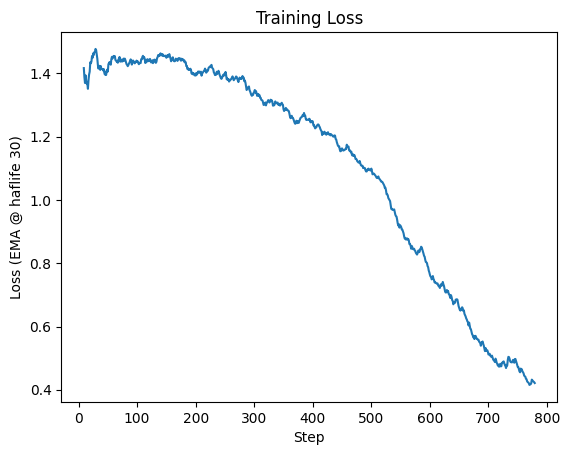

In [ ]:
# @title SFT loss
import pandas as pd
import matplotlib.pyplot as plt
pd.Series(all_losses).ewm(halflife=30, min_periods=10).mean().plot()
plt.xlabel("Step")
plt.ylabel("Loss (EMA @ haflife 30)")
plt.title("Training Loss")
plt.show()


### 2.4 Evaluate SFT policy

In [ ]:
## Run eval loop with fine-tuned model
sft_episodes = {"sft": []}
num_episodes_per_agent = 30

for ep in range(num_episodes_per_agent):
    printmd(f"#### Episode {ep}")
    memory, data, total_reward = episode_rollout(model_lora, gameFold="test", thinking=False, seed=ep * 123)
    sft_episodes['sft'].append({"ep": ep, "total_reward": total_reward, "memory": memory, "data": data})

## save results
with open(f"{target_dir}/episodes_sft_agent.json", "w") as f:
    json.dump(sft_episodes, f)

## print an episode
printmd('\n\n'.join(sft_episodes['sft'][0]['memory']))

#### Episode 0

Episode Progress: 0it [00:00, ?it/s]

#### Episode 1

Episode Progress: 0it [00:00, ?it/s]

#### Episode 2

Episode Progress: 0it [00:00, ?it/s]

#### Episode 3

Episode Progress: 0it [00:00, ?it/s]

#### Episode 4

Episode Progress: 0it [00:00, ?it/s]

#### Episode 5

Episode Progress: 0it [00:00, ?it/s]

#### Episode 6

Episode Progress: 0it [00:00, ?it/s]

#### Episode 7

Episode Progress: 0it [00:00, ?it/s]

#### Episode 8

Episode Progress: 0it [00:00, ?it/s]

#### Episode 9

Episode Progress: 0it [00:00, ?it/s]

#### Episode 10

Episode Progress: 0it [00:00, ?it/s]

#### Episode 11

Episode Progress: 0it [00:00, ?it/s]

#### Episode 12

Episode Progress: 0it [00:00, ?it/s]

#### Episode 13

Episode Progress: 0it [00:00, ?it/s]

#### Episode 14

Episode Progress: 0it [00:00, ?it/s]

#### Episode 15

Episode Progress: 0it [00:00, ?it/s]

#### Episode 16

Episode Progress: 0it [00:00, ?it/s]

#### Episode 17

Episode Progress: 0it [00:00, ?it/s]

#### Episode 18

Episode Progress: 0it [00:00, ?it/s]

#### Episode 19

Episode Progress: 0it [00:00, ?it/s]

#### Episode 20

Episode Progress: 0it [00:00, ?it/s]

#### Episode 21

Episode Progress: 0it [00:00, ?it/s]

#### Episode 22

Episode Progress: 0it [00:00, ?it/s]

#### Episode 23

Episode Progress: 0it [00:00, ?it/s]

#### Episode 24

Episode Progress: 0it [00:00, ?it/s]

#### Episode 25

Episode Progress: 0it [00:00, ?it/s]

#### Episode 26

Episode Progress: 0it [00:00, ?it/s]

#### Episode 27

Episode Progress: 0it [00:00, ?it/s]

#### Episode 28

Episode Progress: 0it [00:00, ?it/s]

#### Episode 29

Episode Progress: 0it [00:00, ?it/s]

`[Task]`: Your task is to pick up objects, then place them in their usual locations in the environment.

`[Starting Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 1`

`[Time]` 13:01:04

`[Valid Actions]`: ['open kitchen cupboard', 'take newspaper', 'take dirty mesh skimmer', 'open trash can', 'open fridge', 'open cutlery drawer', 'move west', 'inventory', 'open dishwasher', 'look around']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 2`

`[Time]` 13:01:04

`[Valid Actions]`: ['look around', 'inventory', 'open door to west', 'move west', 'open wastepaper basket', 'close door to west', 'take can opener', 'take milk', 'move east']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 3`

`[Time]` 13:01:04

`[Valid Actions]`: ['take newspaper', 'open fridge', 'move west', 'open trash can', 'open kitchen cupboard', 'look around', 'open dishwasher', 'inventory', 'take dirty mesh skimmer', 'open cutlery drawer']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. To the West you see a closed wood door. 

###  `Action step 4`

`[Time]` 13:01:04

`[Valid Actions]`: ['inventory', 'open door to west', 'move west', 'take milk', 'take can opener', 'close door to west', 'move east', 'look around', 'open wastepaper basket']

`[Action]`: open door to west

`[Reward]`: 0.00

`[Obs]`: You open the wood door, revealing the bedroom. 

###  `Action step 5`

`[Time]` 13:01:04

`[Valid Actions]`: ['look around', 'inventory', 'take can opener', 'open door to west', 'open wastepaper basket', 'take milk', 'move west', 'move east', 'close door to west']

`[Action]`: look around

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. In one part of the room you see a can opener. There is also a milk. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 6`

`[Time]` 13:01:05

`[Valid Actions]`: ['close door to west', 'look around', 'inventory', 'move east', 'open door to west', 'move west', 'take can opener', 'open wastepaper basket', 'take milk']

`[Action]`: take milk

`[Reward]`: 0.12

`[Obs]`: You take the milk.

###  `Action step 7`

`[Time]` 13:01:05

`[Valid Actions]`: ['put milk in coffee table', 'put milk in book case', 'move west', 'put milk in arm chair', 'put milk in TV stand', 'inventory', 'move east', 'put milk in sofa', 'take can opener', 'put milk in side table', 'close door to west', 'open wastepaper basket', 'look around', 'put milk in end table', 'open door to west']

`[Action]`: take can opener

`[Reward]`: 0.12

`[Obs]`: You take the can opener.

###  `Action step 8`

`[Time]` 13:01:05

`[Valid Actions]`: ['move west', 'put can opener in arm chair', 'open wastepaper basket', 'put can opener in book case', 'move east', 'put milk in book case', 'put milk in arm chair', 'put can opener in sofa', 'put milk in side table', 'put milk in sofa', 'close door to west', 'put milk in coffee table', 'put can opener in TV stand', 'look around', 'put can opener in end table', 'open door to west', 'put can opener in coffee table', 'put milk in TV stand', 'inventory', 'put can opener in side table', 'put milk in end table']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 9`

`[Time]` 13:01:06

`[Valid Actions]`: ['put can opener in dining chair', 'open fridge', 'take dirty mesh skimmer', 'move west', 'put can opener in counter', 'put milk in counter', 'take newspaper', 'open trash can', 'open dishwasher', 'put milk in dining chair', 'look around', 'inventory', 'open kitchen cupboard', 'open cutlery drawer']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 10`

`[Time]` 13:01:06

`[Valid Actions]`: ['look around', 'put can opener in side table', 'put can opener in end table', 'put milk in coffee table', 'inventory', 'put milk in book case', 'put milk in arm chair', 'open wastepaper basket', 'put milk in side table', 'put can opener in book case', 'open door to west', 'put can opener in sofa', 'put can opener in TV stand', 'put milk in sofa', 'put can opener in arm chair', 'put milk in end table', 'put milk in TV stand', 'put can opener in coffee table', 'move east', 'close door to west', 'move west']

`[Action]`: move east

`[Reward]`: 0.00

`[Obs]`: You are in the kitchen. In one part of the room you see a stove. There is also an oven. You also see a fridge that is closed. In another part of the room you see a counter, that has nothing on it. In one part of the room you see a kitchen cupboard that is closed. There is also a cutlery drawer that is closed. You also see a trash can that is closed. In another part of the room you see a dishwasher that is closed. In one part of the room you see a dining chair, that has nothing on it. There is also a newspaper. You also see a dirty mesh skimmer. 
To the West you see the living room. 

###  `Action step 11`

`[Time]` 13:01:06

`[Valid Actions]`: ['put milk in dining chair', 'open trash can', 'put can opener in dining chair', 'take newspaper', 'put can opener in counter', 'move west', 'put milk in counter', 'open dishwasher', 'open cutlery drawer', 'open kitchen cupboard', 'look around', 'open fridge', 'take dirty mesh skimmer', 'inventory']

`[Action]`: inventory

`[Reward]`: 0.00

`[Obs]`: Inventory: 
  a milk
  a can opener


###  `Action step 12`

`[Time]` 13:01:07

`[Valid Actions]`: ['open trash can', 'look around', 'put can opener in counter', 'put milk in dining chair', 'open cutlery drawer', 'put milk in counter', 'open fridge', 'open dishwasher', 'open kitchen cupboard', 'inventory', 'take newspaper', 'take dirty mesh skimmer', 'put can opener in dining chair', 'move west']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the living room. In one part of the room you see a wastepaper basket that is closed. There is also a book case, that has nothing on it. You also see a TV stand, that has nothing on it. In another part of the room you see a arm chair, that has nothing on it. In one part of the room you see a side table, that has nothing on it. There is also a coffee table, that has nothing on it. You also see a end table, that has nothing on it. In another part of the room you see a sofa, that has nothing on it. 
To the East you see the kitchen. Through an open wood door, to the West you see the bedroom. 

###  `Action step 13`

`[Time]` 13:01:07

`[Valid Actions]`: ['put can opener in sofa', 'move west', 'put can opener in TV stand', 'put milk in arm chair', 'put milk in side table', 'put can opener in arm chair', 'inventory', 'put milk in end table', 'put milk in sofa', 'put milk in TV stand', 'put can opener in end table', 'close door to west', 'open door to west', 'open wastepaper basket', 'put milk in coffee table', 'put milk in book case', 'move east', 'look around', 'put can opener in coffee table', 'put can opener in side table', 'put can opener in book case']

`[Action]`: move west

`[Reward]`: 0.00

`[Obs]`: You are in the bedroom. In one part of the room you see a dressing table, that has nothing on it. There is also a desk chair, that has nothing on it. You also see a desk, that has nothing on it. In another part of the room you see a chest of drawers that is closed. In one part of the room you see a wardrobe that is closed. There is also a night stand, that has nothing on it. You also see a bed, that has nothing on it. 
Through an open wood door, to the East you see the living room. 

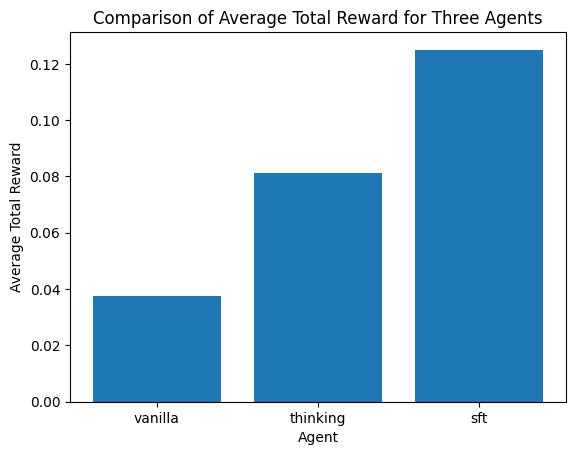

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

all_eps = baseline_episodes | sft_episodes

avg_rewards = {
    a: np.mean([ep["total_reward"] for ep in all_eps[a]])
    for a in ["vanilla", "thinking", "sft"]
}

# make a bar chart
agents = list(avg_rewards.keys())
rewards = list(avg_rewards.values())

plt.bar(agents, rewards)
plt.xlabel("Agent")
plt.ylabel("Average Total Reward")
plt.title("Comparison of Average Total Reward for Three Agents")
plt.show()

# Conclusion: 🤗 What did we learn? 🤔

* 🌎 While prompting techniques are powerful, sometimes we need to ground our agent in a specific task by finetuning the neural network weights of the LLM.
* 🏰 LLMs are to big to be finetuned in the usual way. We need parameter efficient finetuning techniques such as LORA.
* 🧮 A little expert labeled data will go a long long way, even to finetune models with billions of parameters --> SFT
* 🐕 What we didn't cover? Your next steps should be learning about RL for LLMs!

<br>
<img src="https://drive.google.com/uc?export=view&id=1BCv4CkAcwl07yUBEmXcZANmUASPlyyYl" alt="drawing" width="600"/>
